## Notebook Accompanying Email #5: Mean Reversion in Stocks

## Magic

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import urllib3
import datetime as dt
import numpy as np
import plotnine as p9
import polars as pl
import pandas as pd
import yfinance as yf

## Options / Globals

In [18]:
p9.options.figure_size = (12, 5)

## Load Index Data

In [3]:
px = pl.from_dataframe(
    pd.read_csv('index.csv', parse_dates=['Date'])
)

In [4]:
data = (
    px
    .group_by('INDEX', maintain_order=True)
    .agg(
        pl.all(),
        pl.col('Close').pct_change().alias('ret'),
        pl.when(
            pl.col('Close').pct_change().shift(1) > 0
        ).then(1).otherwise(-1).alias('flag')
    )
    .explode(pl.exclude('INDEX'))
    
    .with_columns(
        (pl.col('flag') * pl.col('ret')).alias('pl')
    )
    
    .fill_null(0.0)
    
    .group_by('INDEX', maintain_order=True)
    .agg(
        pl.all(),
        (1 + pl.col('pl')).cum_prod().alias('cpl'),
        (pl.col('Close') / pl.col('Close').first()).alias('indx')
    )
    .explode(pl.exclude('INDEX'))

)

## Trend-Following and Mean-Reversion performance of Stock Indexes

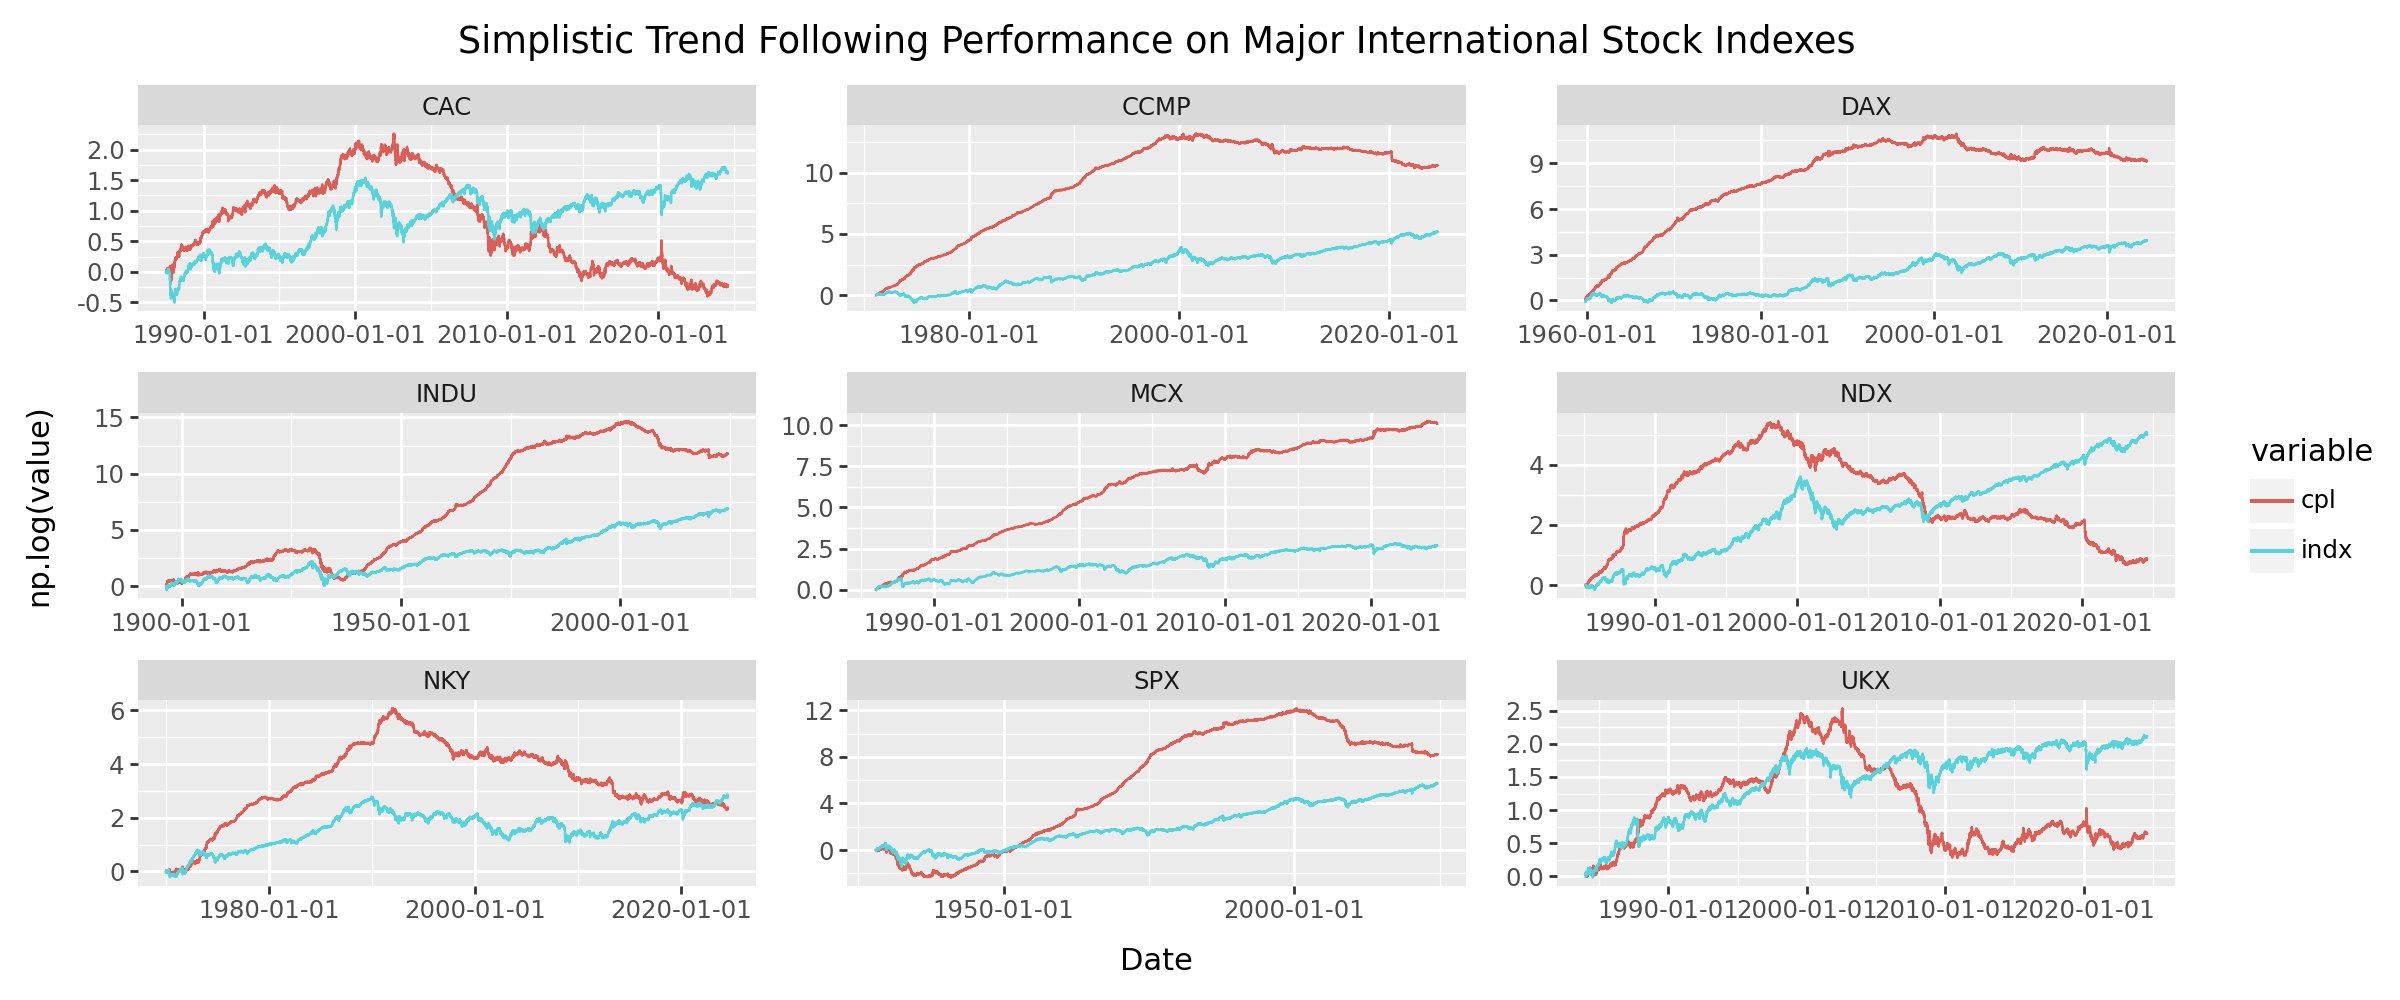

In [19]:
(
    data
    # .filter(pl.col('INDEX') == INDX)
    .select('Date', 'INDEX', 'cpl', 'indx')
    .unpivot(index=['Date', 'INDEX'])
    .pipe(p9.ggplot)
    + p9.aes(x='Date', y='np.log(value)', color='variable')
    + p9.geom_line()
    + p9.facet_wrap('INDEX', scales='free')
    + p9.ggtitle("Simplistic Trend Following Performance on Major International Stock Indexes")
)

## Signal Analysis for S&P 500

### Prepare the Data

In [6]:
data_ret = (
    data
    .filter(pl.col('INDEX') == 'SPX')
    .select('Date', 'Close')
    .with_columns(
        pl.col('Close').pct_change(1).alias('ret_1'),
        pl.col('Close').pct_change(2).alias('ret_2'),
        pl.col('Close').pct_change(5).alias('ret_5'),

        pl.col('Close').pct_change(1).shift(-1).alias('fret_1'),
        pl.col('Close').pct_change(2).shift(-2).alias('fret_2'),
        pl.col('Close').pct_change(5).shift(-5).alias('fret_5')
    )
    .drop_nulls()
)

### Look at a linear relationship for post 2000

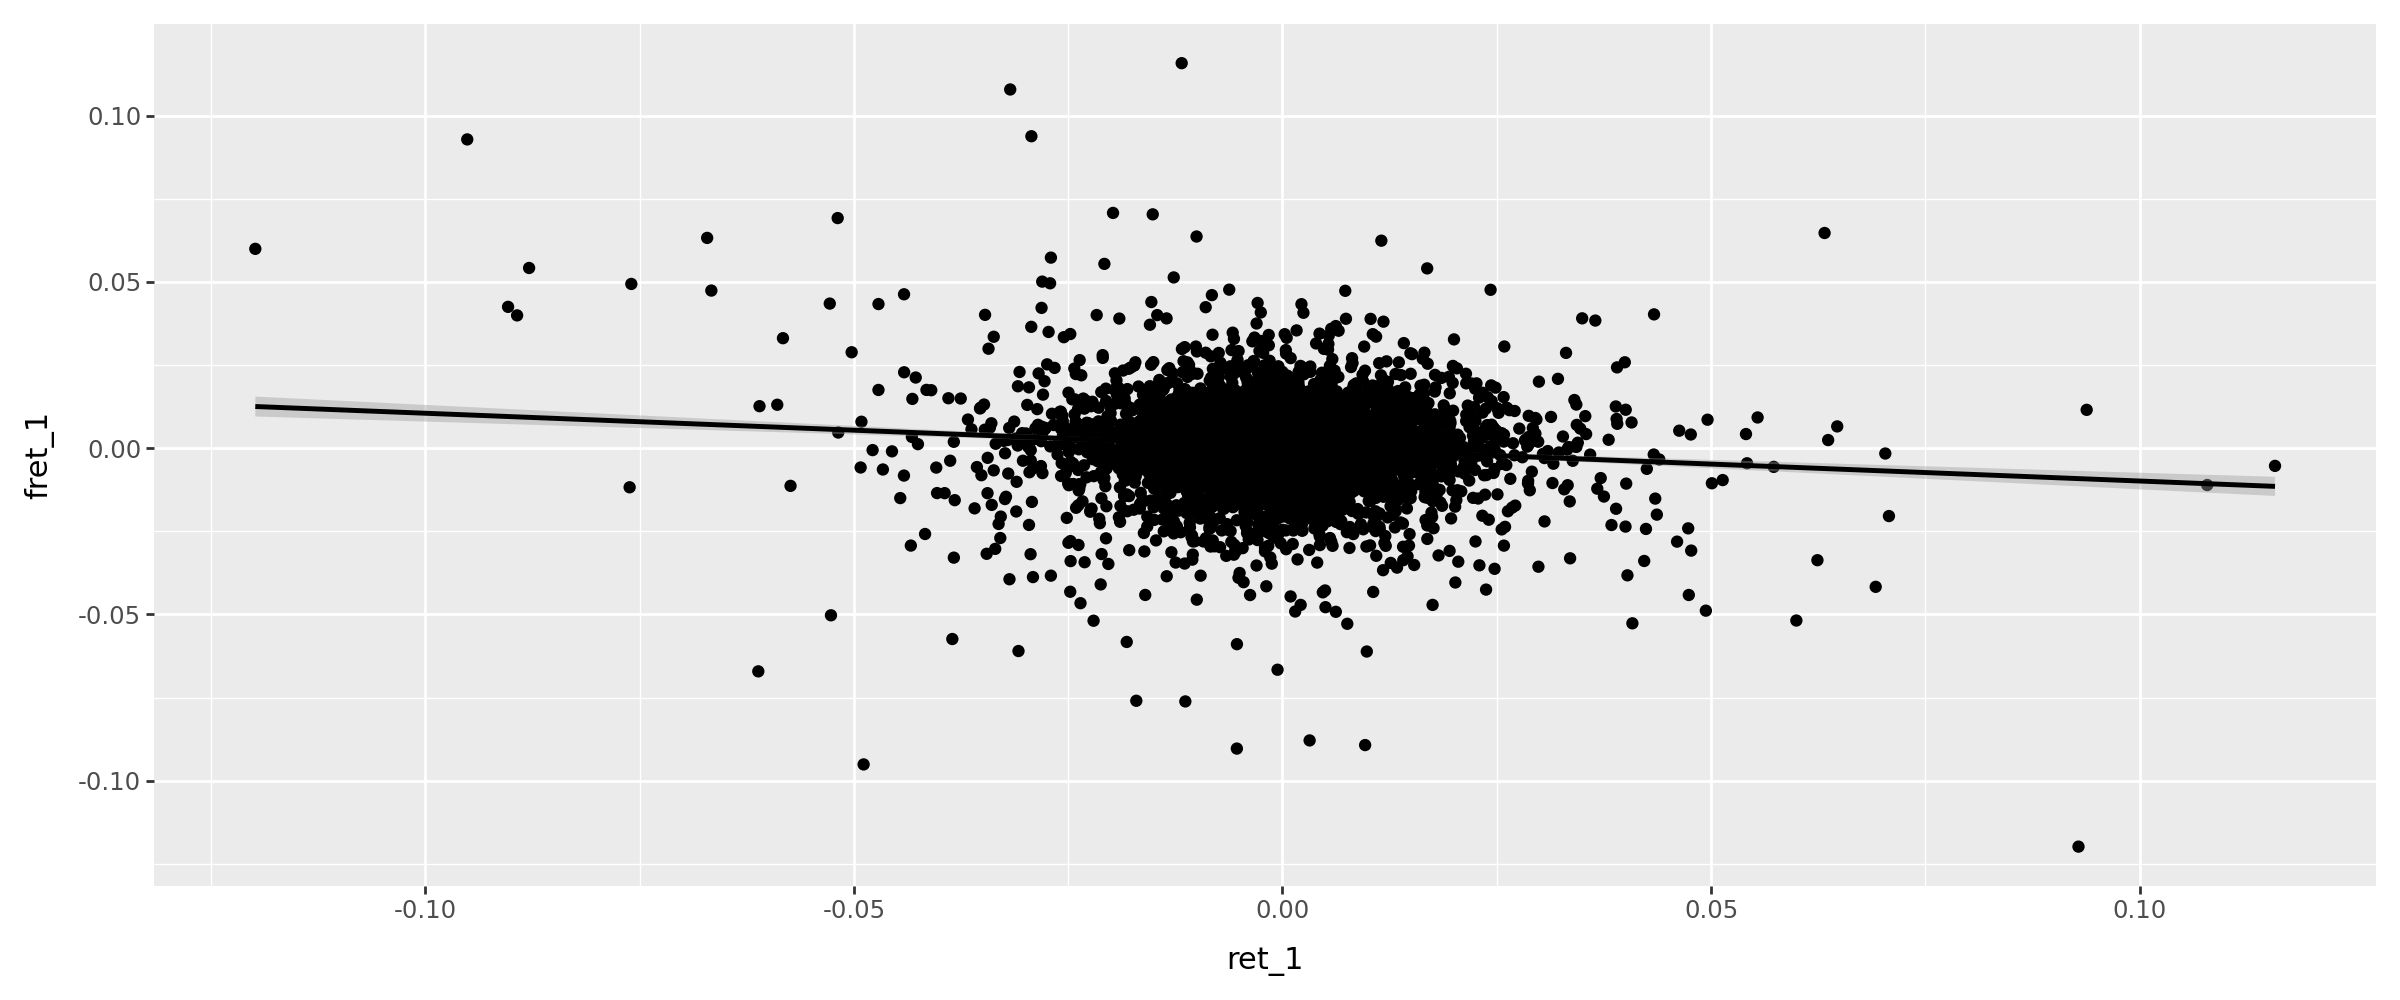

In [21]:
(
    data_ret
    .filter(pl.col('Date') > dt.datetime(2000,1,1))
    .pipe(p9.ggplot)
    + p9.aes(x='ret_1', y='fret_1')
    + p9.geom_point()
    + p9.geom_smooth(method='lm')
)

### Make the relationship clearer by "binning" stuff into up and down

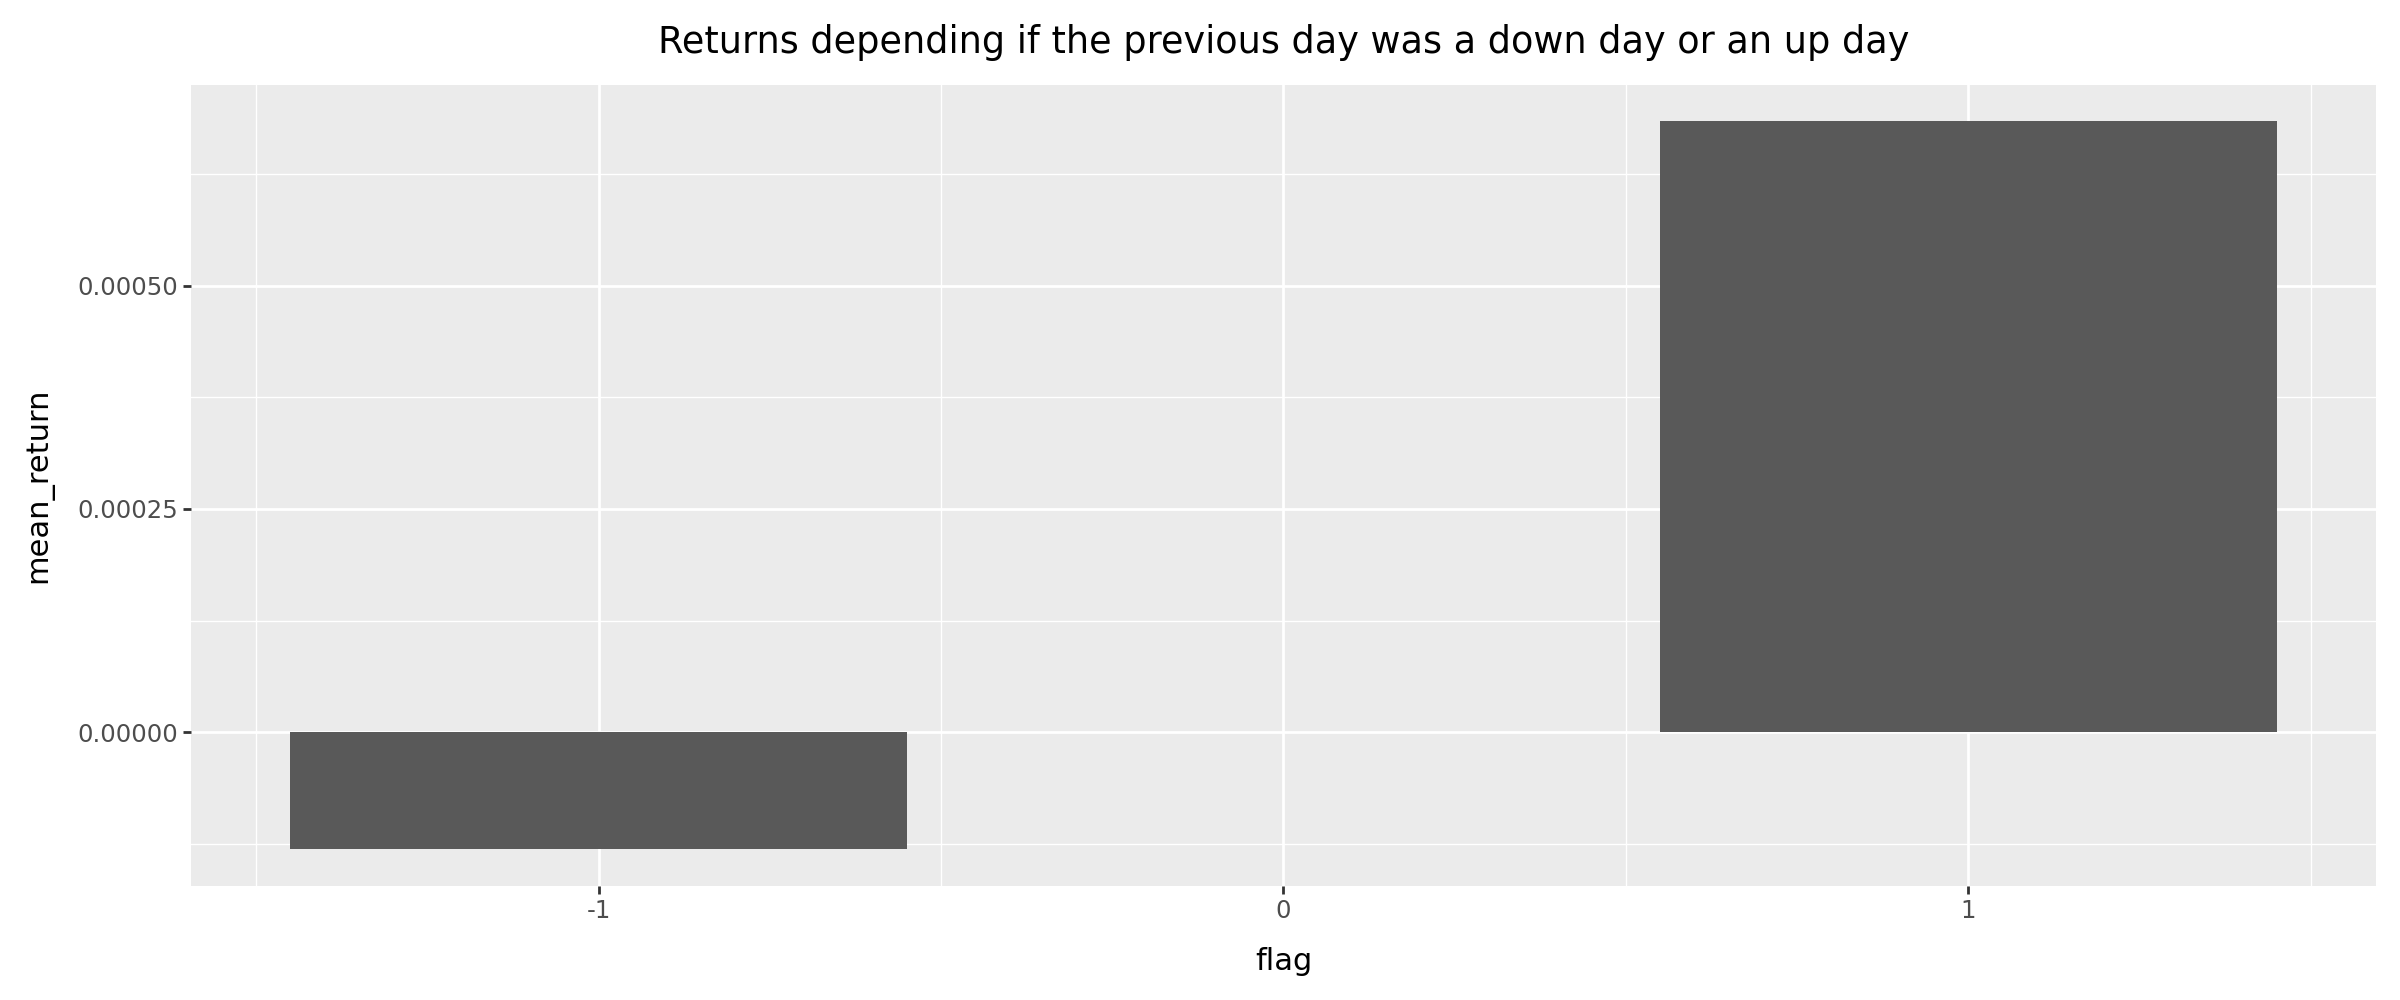

In [25]:
(
    data_ret
    .with_columns(
        pl.when(pl.col('ret_1') < 0).then(-1).otherwise(1).alias('flag')
    )
    .group_by('flag')
    .agg(
        pl.col('fret_1').mean().alias('mean_return')
    )
    .pipe(p9.ggplot)
    + p9.aes(x='flag', y='mean_return')
    + p9.geom_bar(stat='identity')
    + p9.ggtitle('Returns depending if the previous day was a down day or an up day')
)

## Check out the behaviour across decades

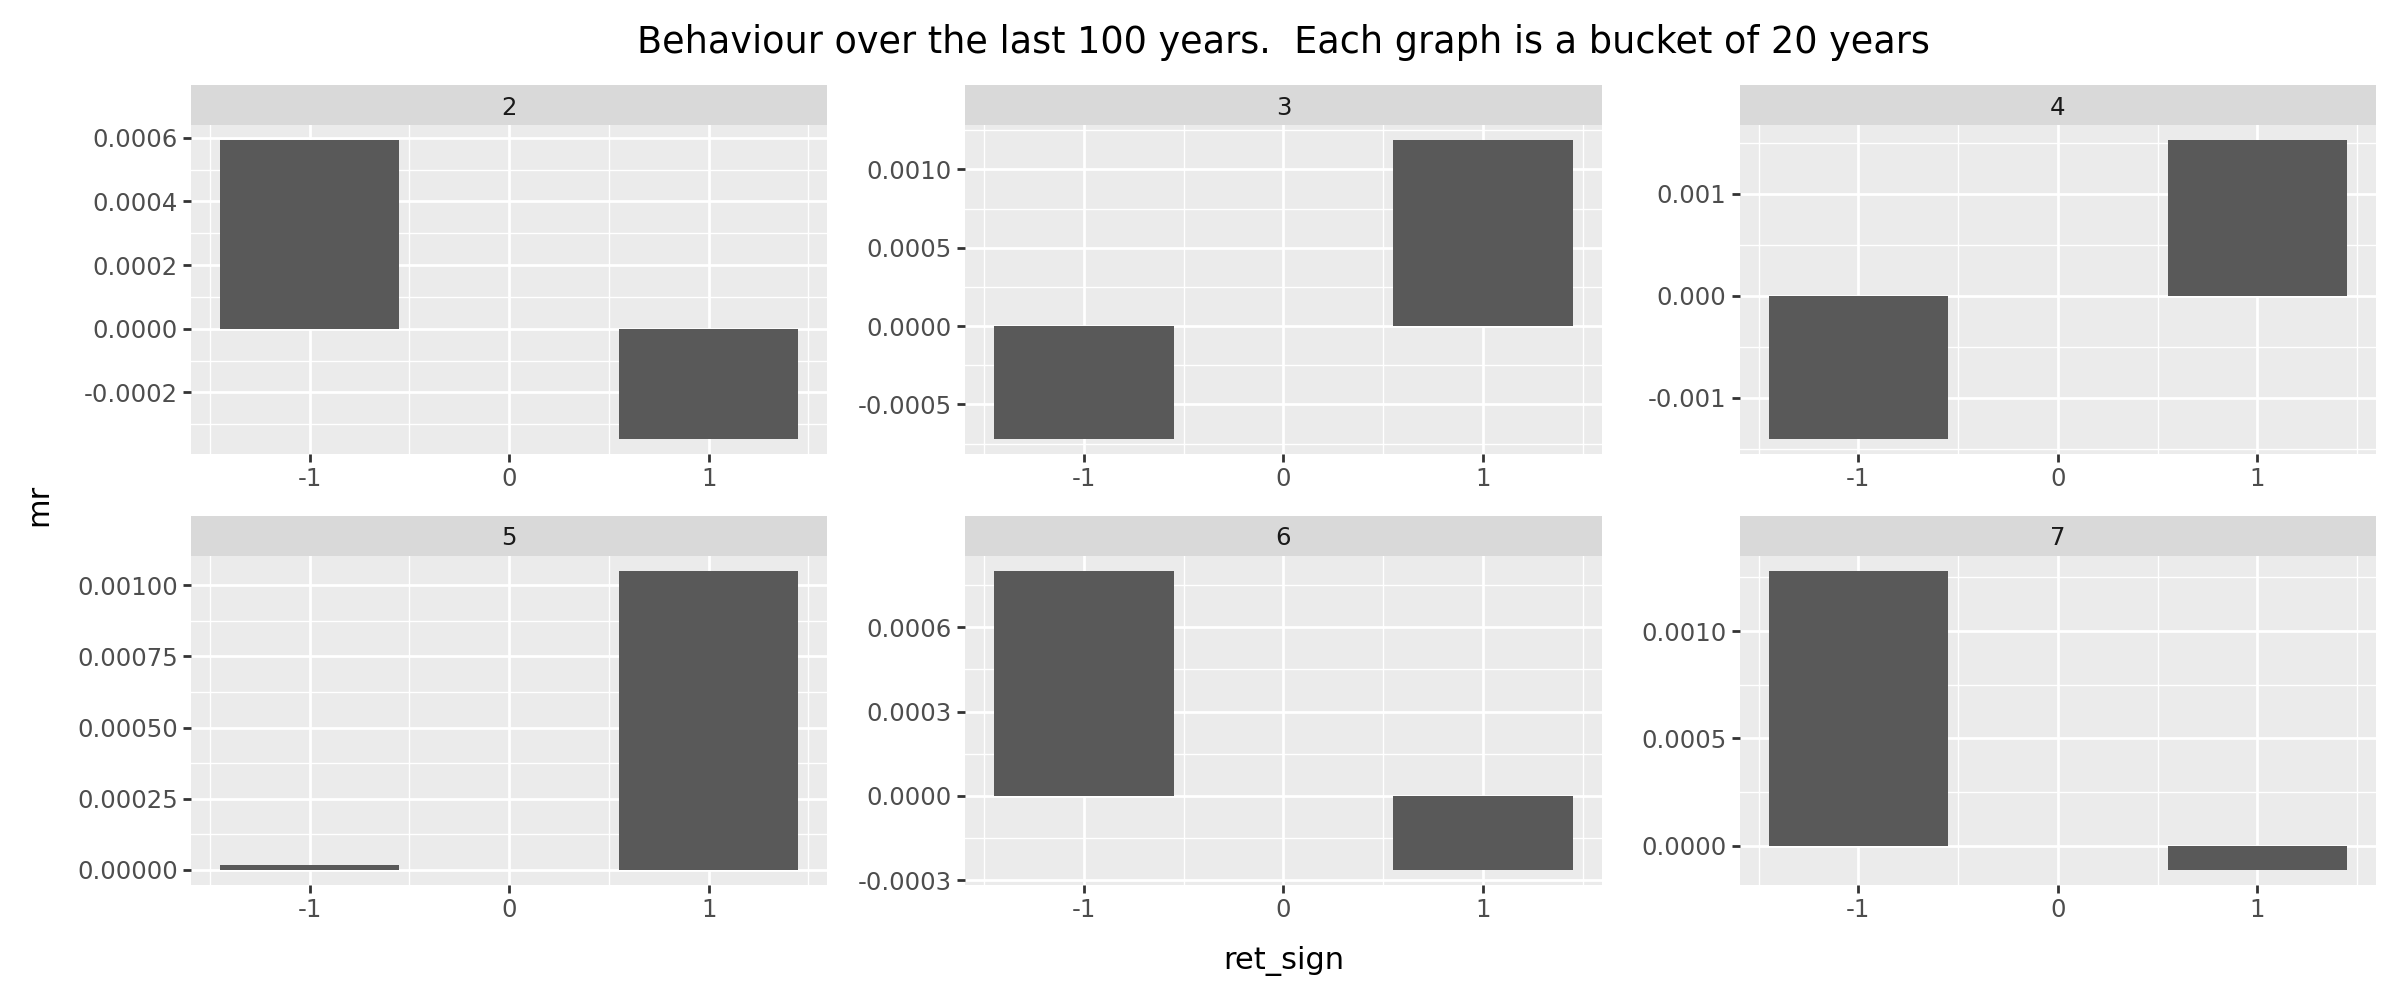

In [29]:
(
    data_ret
    .with_columns(
        pl.when(pl.col('ret_1') < 0).then(-1).otherwise(1).alias('ret_sign'),
        ((pl.col('Date').dt.year() - 1900)// 20 + 1).alias('bidec')
    )
    .group_by(['bidec', 'ret_sign'])
    .agg(
        pl.col('fret_1').mean().alias('mr')
    )
    .pipe(p9.ggplot)
    + p9.aes(x='ret_sign', y='mr')
    + p9.geom_bar(stat='identity')
    + p9.facet_wrap('bidec', scales='free')
    + p9.ggtitle('Behaviour over the last 100 years.  Each graph is a bucket of 20 years')
)

## Validate that Mean Reversion isn't driven by Market Risk

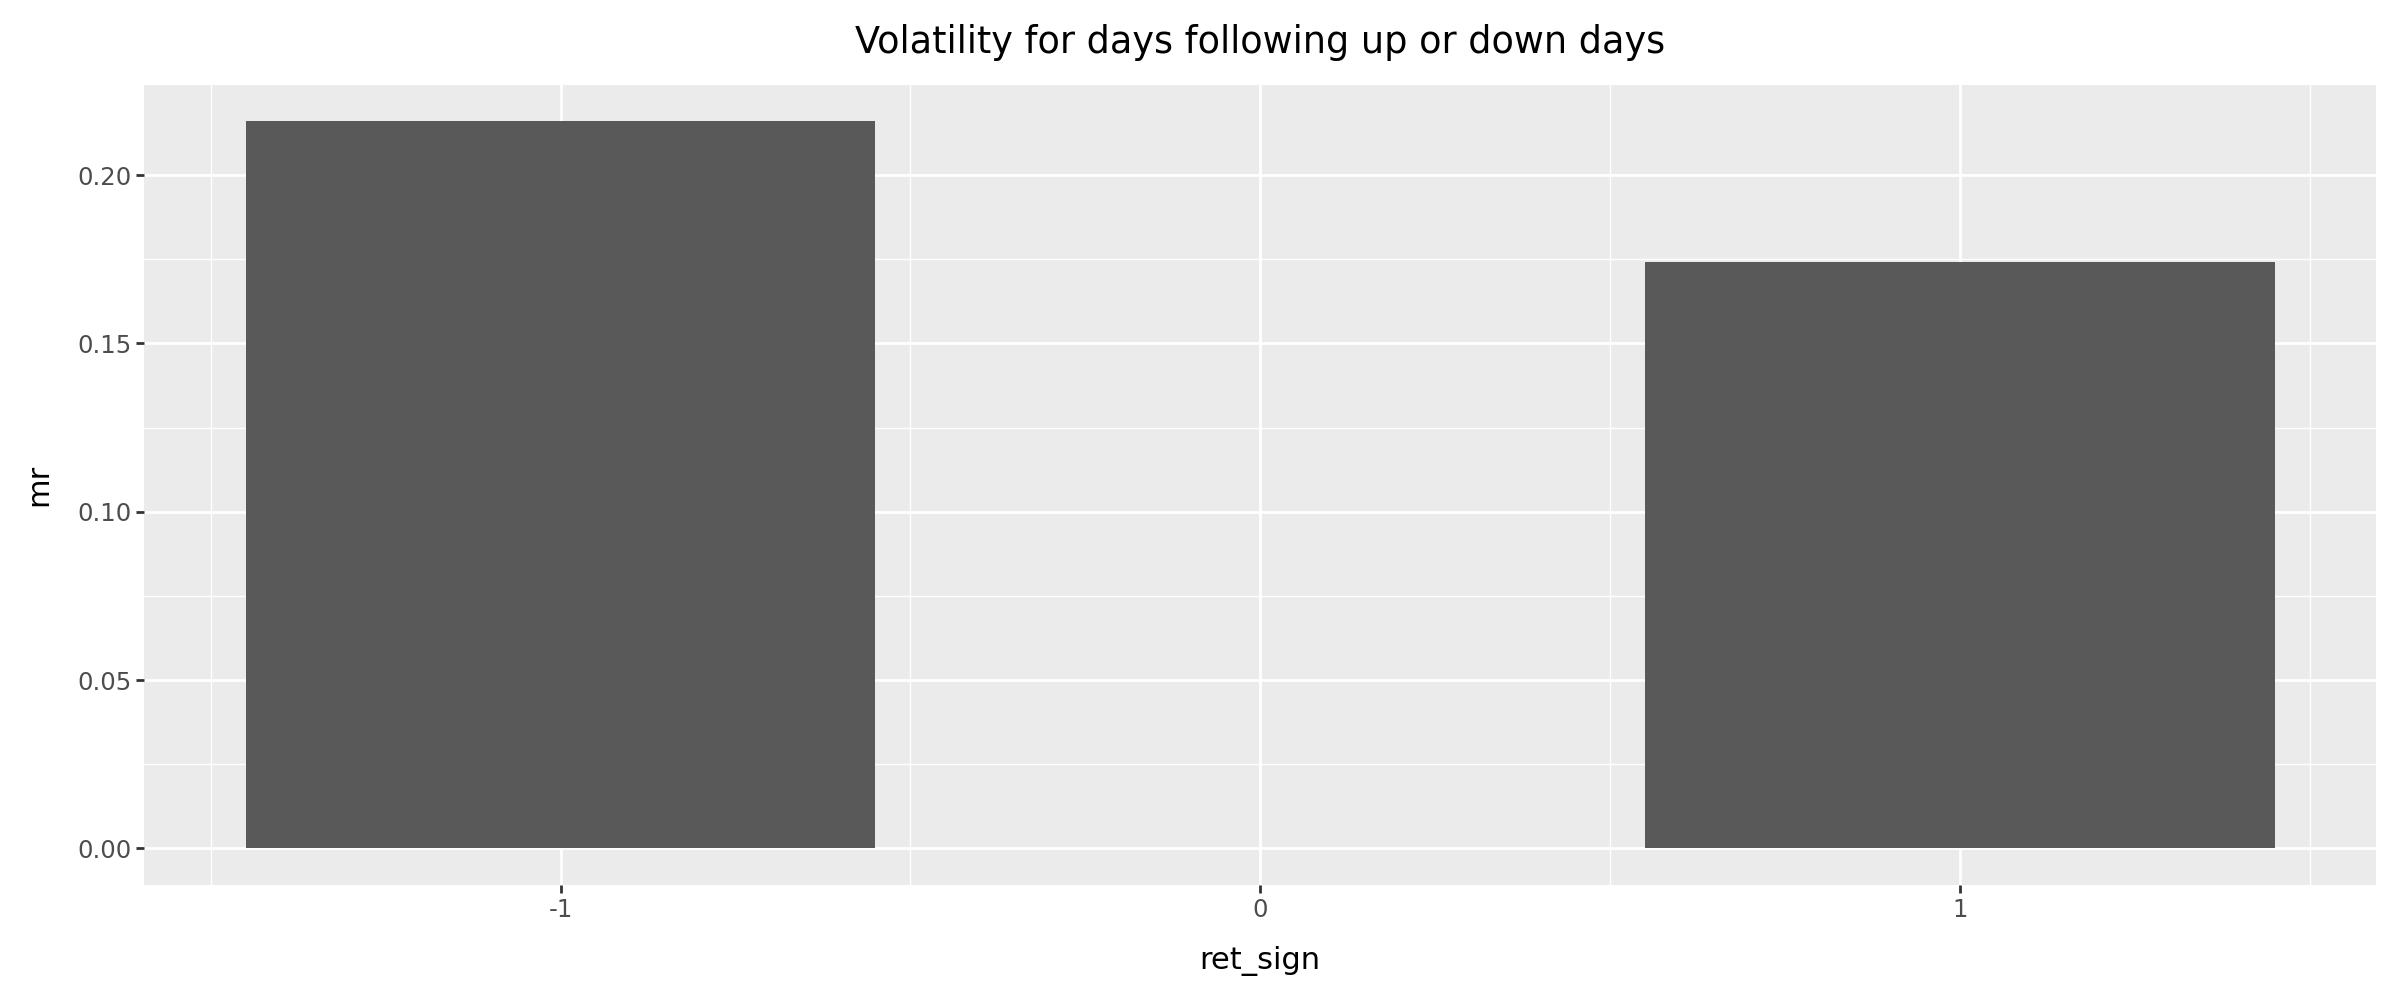

In [35]:
(
    data_ret
    .filter(pl.col('Date') > dt.datetime(2000, 1, 1))
    .with_columns(
        pl.when(pl.col('ret_1') < 0).then(-1).otherwise(1).alias('ret_sign'),
        (pl.col('fret_1') * pl.col('fret_1')).alias('fret_1_sq')
    )
    .group_by('ret_sign')
    .agg(
        (np.sqrt(pl.col('fret_1_sq').mean()) * np.sqrt(252)).alias('mr')
    )
    .pipe(p9.ggplot)
    + p9.aes(x='ret_sign', y='mr')
    + p9.geom_bar(stat='identity')
    + p9.ggtitle('Volatility for days following up or down days')
)